# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [274]:
import numpy as np 
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import keras
import cv2
import matplotlib.pyplot as plt
from focal_loss import BinaryFocalLoss

In [275]:
DATA_DIR = './data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [277]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids) 

In [278]:
import numpy as np 
from PIL import Image as im 
  
def ndarray2image(array, image_name): 
    assert isinstance(array, np.ndarray), f"The given object is not numpy array but rather {array.__class__}"
    refined_array = array.reshape(360, 480)
    data = im.fromarray((refined_array * 255).astype(np.uint8))
    data.save(image_name) 



In [281]:
import os 
def _produce_images(dataset, paths):
    assert (len(paths)==len(dataset), 
        f"Was not able to map,paths size is{len(paths)}"
        f"and dataset size is {dataset}")

    for i in range(len(dataset)):
        image, mask = dataset[i]
        ndarray2image(mask,paths[i])

def extract_class_masks(class_name):
    assert (class_name in Dataset.CLASSES, 
            f"The given class {class_name} is not a compitable option,"
            f"instead use one of the following{Dataset.CLASSES}")
    
    train_dataset = Dataset(x_train_dir, y_train_dir, classes=[class_name])
    valid_dataset = Dataset(x_valid_dir, y_valid_dir, classes=[class_name])
    test_dataset = Dataset(x_test_dir, y_test_dir, classes=[class_name])

    train_paths = os.listdir(x_train_dir)
    valid_paths = os.listdir(x_valid_dir)
    test_paths = os.listdir(x_test_dir)

    # _produce_images(train_dataset, train_paths)
    # _produce_images(valid_dataset, valid_paths)
    _produce_images(test_dataset, test_paths)

# NOTE: that this method extract all the data-sets into the current directory,
# comment the unwanted data-sets and copy manualy or resolve the bug in order
# the seperate them. 
extract_class_masks('road')


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/g1/0ww79qmx64j6rfytk8qzjlg80000gn/T/ipykernel_69559/1183235972.py:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(paths)==len(dataset),
/var/folders/g1/0ww79qmx64j6rfytk8qzjlg80000gn/T/ipykernel_69559/1183235972.py:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (class_name in Dataset.CLASSES,


<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/g1/0ww79qmx64j6rfytk8qzjlg80000gn/T/ipykernel_69559/1028983231.py:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(train_paths)==len(train_dataset),


367
367


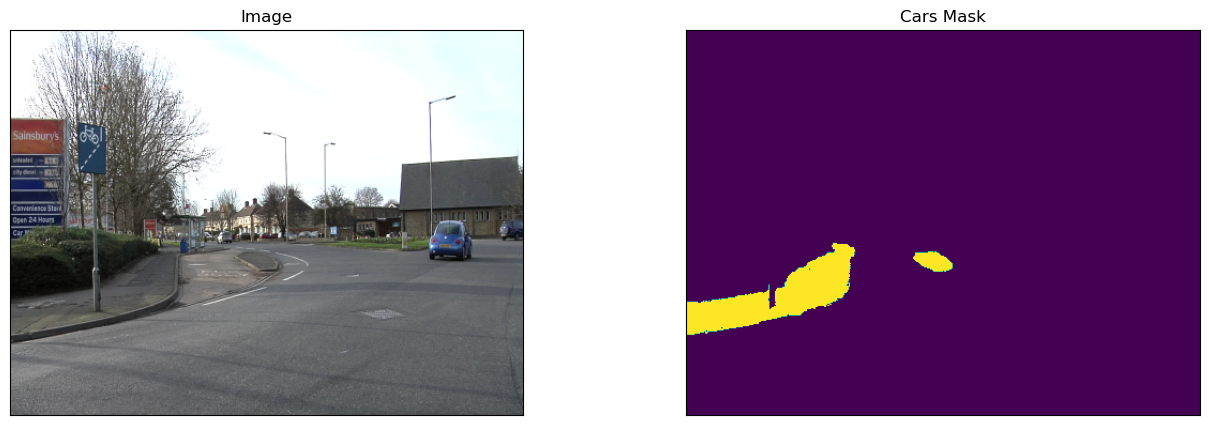

In [269]:

# lets have a look
dataset = Dataset(x_train_dir, y_train_dir, classes=['pavement'])
image, mask = dataset[5]
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),

)

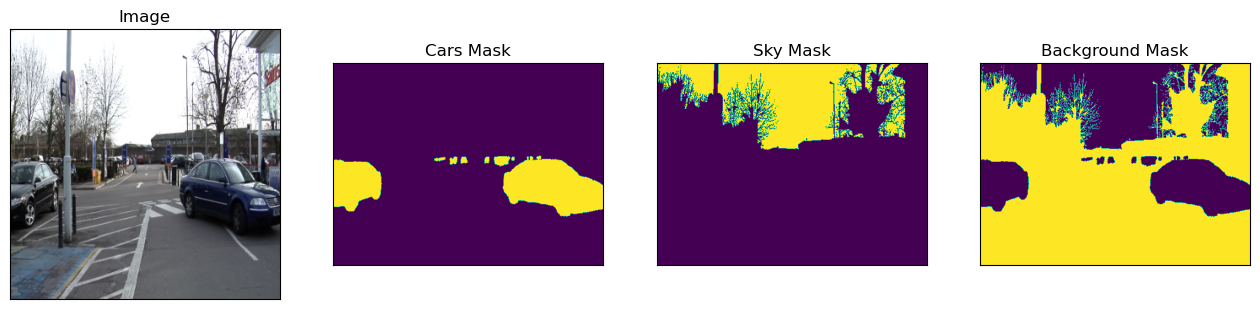

In [51]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'])

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Segmentation model training

In [45]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [46]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['pavement', 'road']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [58]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=n_classes,
    activation=activation,
    input_shape=(256, 256, 3)
)

In [59]:
# define optomizer
optim = keras.optimizers.legacy.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [60]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
)

# define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     keras.callbacks.ReduceLROnPlateau(),
# ]

In [81]:
import keras.callbacks
train_images = np.array([img for img in train_dataset])
validation_images = np.array([img for img in valid_dataset])

# train model
model.fit(
    train_images,
    validation_data=validation_images, 
    batch_size=16,
    verbose=1,
    epochs=EPOCHS, 
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)
# history = model.fit(
#     np.array([]),
#     np.array([]),
#     validation_data=(np.array([]), np.array([])),
#     batch_size=16,
#     epochs=50,
#     verbose=1,
#     callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
#     )

[ WARN:0@43786.091] global loadsave.cpp:248 findDecoder imread_('./data/CamVid/train/0001TP_008460.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


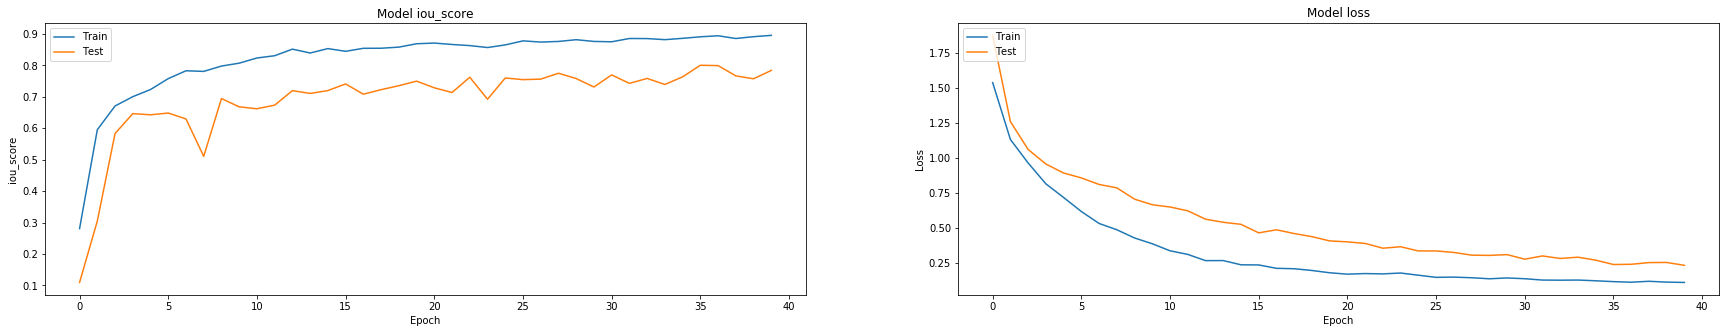

In [25]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [26]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [28]:
# load best weights
model.load_weights('best_model.h5') 

In [29]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.36047
mean iou_score: 0.77471
mean f1-score: 0.84867


# Visualization of results on test dataset

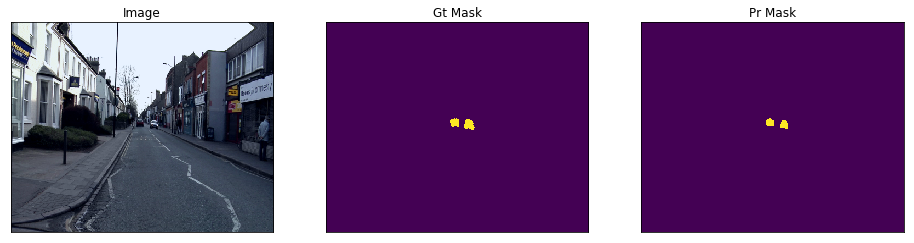

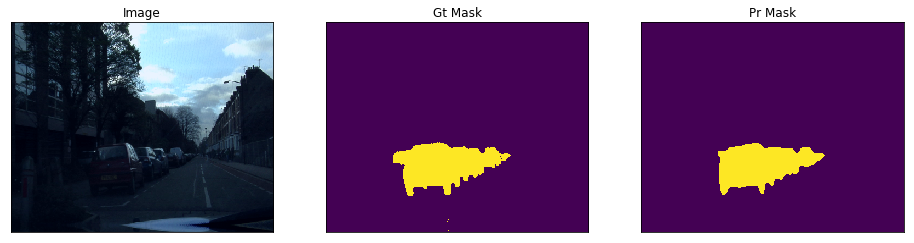

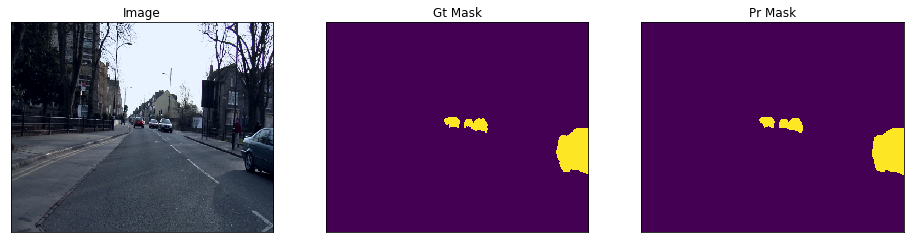

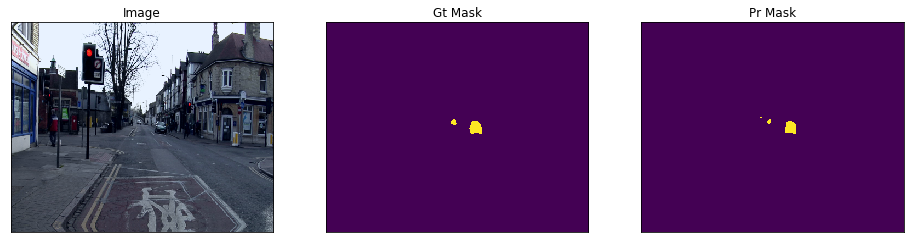

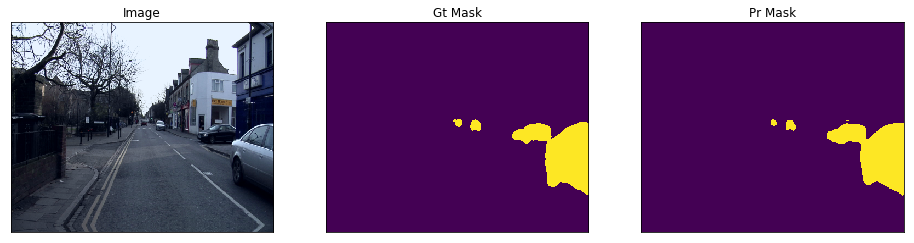

In [31]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )